## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms


## Get data

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=True, transform=transform)
testset = datasets.MNIST("~/.pytorch/MNIST_data/", download=True, train=False, transform=transform)

train_X = trainset.data
train_y = trainset.targets

test_X = testset.data
test_y = testset.targets

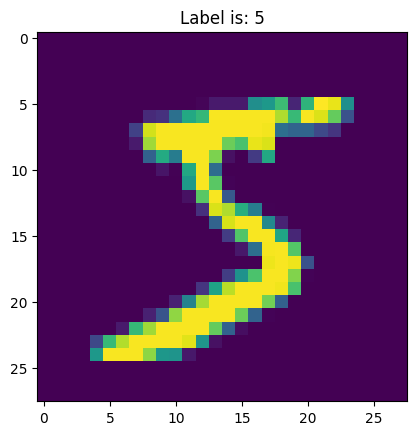

In [4]:
plt.imshow(train_X[0])
plt.title(f"Label is: {train_y[0]}")
plt.show()

## 